<a href="https://colab.research.google.com/github/AminuHabib/AirBnB-R-Analysis-with-R-Studio/blob/main/sklearn_light.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycaret
!pip install plotly
!pip install shap

     |████████████████████████████████| 266kB 6.3MB/s 
     |████████████████████████████████| 102kB 5.1MB/s 
     |████████████████████████████████| 276kB 15.0MB/s 
     |████████████████████████████████| 6.8MB 19.2MB/s 
     |████████████████████████████████| 1.7MB 51.2MB/s 
     |████████████████████████████████| 14.2MB 312kB/s 
     |████████████████████████████████| 245kB 52.3MB/s 
     |████████████████████████████████| 1.8MB 49.9MB/s 
     |████████████████████████████████| 215kB 48.1MB/s 
     |████████████████████████████████| 61kB 5.3MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 153kB 49.9MB/s 
     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 1.1MB 31.2MB/s 
     |████████████████████████████████| 163kB 41.5MB/s 
     |████████████████████████████████| 3.1MB 33.9MB/s 
     |████████████████████████████████| 81kB 6.8MB/s 
     |████████████████████████████████| 604kB 39.6MB/s 
  

In [ ]:
import os
import tarfile #Read and write tar archive files¶
from six.moves import urllib #Six is a Python 2 and 3 compatibility library.
import glob2 #Glob1: Unix style pathname pattern expansion.
#Glob2: Version of the glob module that can capture patterns and supports recursive wildcards
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px #Plotly Express is a terse, consistent, high-level API for creating figures
from pandas.plotting import scatter_matrix
from pycaret.utils import enable_colab
#PyCaret is an open source, low-code machine learning library in Python that 
#allows you to go from preparing your data to deploying your model within minutes in your choice of notebook environment.
import shap #game theoretic approach to explain the output of any machine learning model
enable_colab() 

Colab mode enabled.


## 1. Preparation:

In [ ]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/" #Root url where the data is located
HOUSING_URL = f"{DOWNLOAD_ROOT}datasets/housing/housing.tgz" # define a full path of the file to be downloaded

In [ ]:
HOUSING_PATH = os.path.join("datasets", "housing") # define a path with current directory and "housing" in the local colab env
HOUSING_SUFFIX = "housing.tgz"

In [ ]:
def download_housing_data(housing_url=HOUSING_URL, 
                       housing_path=HOUSING_PATH): 
  '''
  this function downloads the data and save it to a given path
  '''                     

  os.makedirs(housing_path, exist_ok=True) #Create the folder tree in one batch. Also checks if it exists already
  tgz_path = os.path.join(housing_path, "housing.tgz") #Create filepath for the compressed data
  response = urllib.request.urlretrieve(housing_url, tgz_path) #Download data to the compressed .tgz file
  print(response)

In [ ]:
def unzip_housing_data(housing_path=HOUSING_PATH, housing_suffix = HOUSING_SUFFIX):
  '''
  this function extracts the data and save it to a given path
  '''  
  
  tgz_path = os.path.join(housing_path, housing_suffix) #output of the tgz file (compressed on disk)

  with tarfile.open(tgz_path, 'r:*') as housing_tgz: # open a file with the "with clause for neater code"
    housing_tgz.extractall(path=housing_path) 

  all_files = glob2.glob(os.path.join(housing_path,"*")) # list all files in the main subfolder (* as wildcard)
  n_files = len(all_files) # compute the number of files

  print(f"there is : {n_files} decompressed in the original folder") 
  return(all_files) # the files list as the final output

As you can see, we have downloaded the file thanks to the link provided.
We then extract the file ( .tgz) file
Finally we made sure that the output file (.csv) file is present

In [ ]:
download_housing_data()
unzip_housing_data()

('datasets/housing/housing.tgz', <http.client.HTTPMessage object at 0x7f911f215050>)
there is : 2 decompressed in the original folder


['datasets/housing/housing.csv', 'datasets/housing/housing.tgz']

## 2. Exploration :

In [ ]:
housing_dataframe = pd.read_csv('datasets/housing/housing.csv') # we read the data inside the variable housing_dataframe
housing_dataframe.head(5) # we limit the view to a couple of rows

longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY

[5 rows x 10 columns]

#Df insights:
  -In .describe() we obtain the stat metrics for the **numeric** variables/columns
  -The variables are in different orders of magnitude: need for normalization/standardization.
  -

In [ ]:
def visualize(data_frame,
              columns, 
              n_cols=2, 
              n_rows=4, 
              size=20):
  '''
  Util function: boxplot organized on a grid the user can specify to keep the data exploration manageable
  '''
  
  fig, axs = plt.subplots(n_rows, n_cols, clear=True) #Create the subplots in the figure
  fig.set_size_inches(size, size) #size is one of our parameter
  unrolled_axs= axs.flatten() #Create a vector for the data in the axis
  for idx,col in enumerate(columns): #Iterate through the columns creating the subplots
    data_frame[[col]].boxplot(ax=unrolled_axs[idx])
  fig
  #return fig

In [ ]:
def prettify(axs,
    n_rows=7, 
    size=20):
  '''
  Util function: used to prettify the look of the  off the shelf histogram
  '''

  unrolled_axs = axs.flatten()
  l = []
  fig, new_axs = plt.subplots(n_rows, int((unrolled_axs.shape[0])/float(n_rows)))
  dest_axs = new_axs.reshape(len(unrolled_axs))
  fig.set_size_inches(20, 20)
  

  for idx, an_ax in enumerate(unrolled_axs):
    print(an_ax)
    l.append(an_ax)
  new_axs = np.array(l).reshape(n_rows, int((unrolled_axs.shape[0])/float(n_rows)))
  return fig

#3. Features 

## a.Original features: (MACRO glance)

let's discover the variables and their  simple statistics (
mean, quantiles, median and std)

In [ ]:
housing_dataframe.describe()

longitude      latitude  ...  median_income  median_house_value
count  20640.000000  20640.000000  ...   20640.000000        20640.000000
mean    -119.569704     35.631861  ...       3.870671       206855.816909
std        2.003532      2.135952  ...       1.899822       115395.615874
min     -124.350000     32.540000  ...       0.499900        14999.000000
25%     -121.800000     33.930000  ...       2.563400       119600.000000
50%     -118.490000     34.260000  ...       3.534800       179700.000000
75%     -118.010000     37.710000  ...       4.743250       264725.000000
max     -114.310000     41.950000  ...      15.000100       500001.000000

[8 rows x 9 columns]

In [ ]:
	housing_dataframe["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

With value_counts() we can see the frequency fo the different distict values in each co <br>. For this dataset we can get some intuition towards were more houses are common / uncommon

In [ ]:
columns = ["housing_median_age",
          "total_rooms",
          "total_bedrooms",
          "population",
          "households",
          "median_income",
          "median_house_value"]

In [ ]:
numeric_simple_columns = pd.DataFrame(housing_dataframe[columns].describe().loc["mean",:]).transpose()
numeric_simple_columns

housing_median_age  total_rooms  ...  median_income  median_house_value
mean           28.639486  2635.763081  ...       3.870671       206855.816909

[1 rows x 7 columns]

In [ ]:
housing_dataframe[columns].describe()

housing_median_age   total_rooms  ...  median_income  median_house_value
count        20640.000000  20640.000000  ...   20640.000000        20640.000000
mean            28.639486   2635.763081  ...       3.870671       206855.816909
std             12.585558   2181.615252  ...       1.899822       115395.615874
min              1.000000      2.000000  ...       0.499900        14999.000000
25%             18.000000   1447.750000  ...       2.563400       119600.000000
50%             29.000000   2127.000000  ...       3.534800       179700.000000
75%             37.000000   3148.000000  ...       4.743250       264725.000000
max             52.000000  39320.000000  ...      15.000100       500001.000000

[8 rows x 7 columns]

In [ ]:
housing_dataframe[columns].describe().loc["mean",:]

housing_median_age        28.639486
total_rooms             2635.763081
total_bedrooms           537.870553
population              1425.476744
households               499.539680
median_income              3.870671
median_house_value    206855.816909
Name: mean, dtype: float64

In [ ]:
numeric_simple_columns = pd.DataFrame(housing_dataframe[columns].describe().loc["mean",:]).transpose()
numeric_simple_columns

housing_median_age  total_rooms  ...  median_income  median_house_value
mean           28.639486  2635.763081  ...       3.870671       206855.816909

[1 rows x 7 columns]

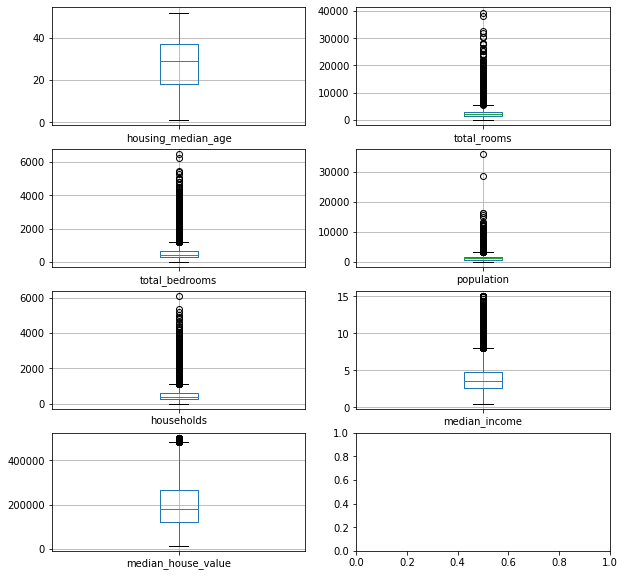

In [ ]:
visualize(housing_dataframe,
              columns, 
              n_cols=2, 
              n_rows=4, 
              size=10)

In [ ]:
housing_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


- There is one non numerical variable : ocean_proximity     
- There one variable for which there are missing values: total_bedrooms

In [ ]:
housing_dataframe['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

lists of all possible values taken by the categorical variable 'ocean_proximity'

In [ ]:
#it's the correlation matrix between numerical variables
housing_corr = housing_dataframe[columns].corr()
print(housing_corr)
housing_corr_cols = housing_dataframe[columns].columns
print(housing_corr_cols)

                    housing_median_age  ...  median_house_value
housing_median_age            1.000000  ...            0.105623
total_rooms                  -0.361262  ...            0.134153
total_bedrooms               -0.320451  ...            0.049686
population                   -0.296244  ...           -0.024650
households                   -0.302916  ...            0.065843
median_income                -0.119034  ...            0.688075
median_house_value            0.105623  ...            1.000000

[7 rows x 7 columns]
Index(['housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
       'households', 'median_income', 'median_house_value'],
      dtype='object')


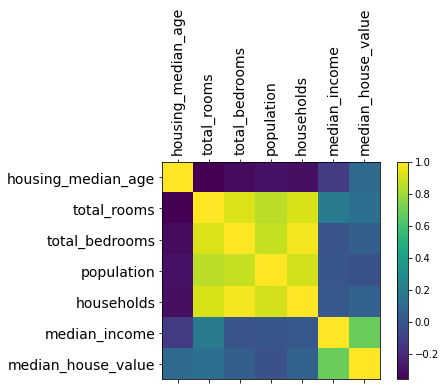

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(housing_corr, interpolation='nearest')
fig.colorbar(cax)

plt.xticks(np.arange(len(housing_corr_cols)), housing_corr_cols, fontsize=14, rotation=90)
plt.yticks(np.arange(len(housing_corr_cols)), housing_corr_cols, fontsize=14, rotation=0)

#plt.title("Correlation matrix")
plt.show()

- Yellow color: best correlation => we can observe tyhe diagnal is in yellow
- plt.xticks is for ticks on axis: first we put the number, then the names to write
- rotate allow to rotate the name on x axis

- total_rooms is strongly correlated with itself, total_bedrooms, population and households
=> we can perform first a PCA to reduce the number of variables

We can observe 2 groups of heavily correlated variates :

group 1

    households
    total_rooms
    total_bedrooms
    population

group2

    median_income
    median_house_value

We can observe 2 other low correlated variates associations :

housing median age:

    households
    total_rooms
    total_bedrooms
    population

median_income:

    housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households"

median_house_value:

    housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households"



## d. Features engineering:

the ratios below are trying to get otehr insights:
- total_rooms/households -> is it a rural area, urban area?
- bedrooms/households -> is it a rural area, densely inhabited 
- total_rooms/households -> is it a rich area (potentially business area)
- bedrooms/households -> is it a rich area (potentially residential area)
- bedrooms/population -> is it a place where inhabitants have difficulty in finding a location?

In [ ]:
housing_dataframe["total_rooms/households"]= housing_dataframe["total_rooms"]/housing_dataframe["households"]

In [ ]:
housing_dataframe["total_rooms/median_income"]= housing_dataframe["total_rooms"]/housing_dataframe["median_income"]

In [ ]:
housing_dataframe["total_bedrooms/median_income"]= housing_dataframe["total_bedrooms"]/housing_dataframe["median_income"]

In [ ]:
housing_dataframe["total_bedrooms/population"]= housing_dataframe["total_bedrooms"]/housing_dataframe["population"]

In [ ]:
housing_dataframe["total_bedrooms/total_rooms"]= housing_dataframe["total_bedrooms"]/housing_dataframe["total_rooms"]

In [ ]:
list1=['a', 'b', 'c']
list2=[1,2,3]

In [ ]:
 for feature1, feature2 in enumerate(zip(list1, list2)):
    print(feature1, feature2)

0 ('a', 1)
1 ('b', 2)
2 ('c', 3)


In [ ]:
housing_dataframe = pd.read_csv('datasets/housing/housing.csv') # we read the data inside the variable housing_dataframe
housing_dataframe.head(5) # we limit the view to a couple of rows

longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY

[5 rows x 10 columns]

In [ ]:
def ratio_features(dataframe, list_numerator, list_denominator):
  ''' 
  the 2 inpout lists should have the same length,  
  the function returns the ratio of the values of the lists one by one ("parallel") 

  '''
  assert len(list_numerator) == len(list_denominator), "the lists don't have the same size"   # check that the lists have the same length. If not, interrupt with the comment
 
  data_frame = dataframe.copy()                                     # to keep track of the original dataframe (default: deep=True does a deep copy)
                                                                    # it is created every time, so no risk of appending this new dataframe when the function is run several times
  for feature1, feature2 in zip(list_numerator, list_denominator):  # we use "zip" to be able to iterate on both lists
    ratio = data_frame[feature1]/data_frame[feature2]               #calculate the ratio 
    data_frame[str(feature1) + '/' + str(feature2)] = ratio        # adding the new column to the dataframe

  return data_frame                                                # we need to return the new dataframe

In [ ]:
list1 = ["total_bedrooms","total_rooms","total_rooms","total_bedrooms","total_bedrooms", "total_bedrooms"]
list2 = ["households","households","median_income","median_income","population","total_rooms"] 
dataframe_enriched = ratio_features(housing_dataframe, list1, list2)

In [ ]:
dataframe_enriched.head()

longitude  latitude  ...  total_bedrooms/population  total_bedrooms/total_rooms
0    -122.23     37.88  ...                   0.400621                    0.146591
1    -122.22     37.86  ...                   0.460641                    0.155797
2    -122.24     37.85  ...                   0.383065                    0.129516
3    -122.25     37.85  ...                   0.421147                    0.184458
4    -122.25     37.85  ...                   0.495575                    0.172096

[5 rows x 16 columns]

In [ ]:
housing_dataframe.head()

longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY

[5 rows x 10 columns]

In [ ]:
columns_ratios = ["total_rooms/households",
          "total_bedrooms/households",
          "total_rooms/median_income",
          "total_bedrooms/median_income",
          "total_bedrooms/total_rooms",
          "total_bedrooms/population"]

In [ ]:
pd.DataFrame(dataframe_enriched[columns_ratios].describe().loc["mean",:]).transpose()        #same as this morning but with ratio columns only

total_rooms/households  ...  total_bedrooms/population
mean                   5.429  ...                   0.403304

[1 rows x 6 columns]

In [ ]:
dataframe_enriched.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'total_bedrooms/households',
       'total_rooms/households', 'total_rooms/median_income',
       'total_bedrooms/median_income', 'total_bedrooms/population',
       'total_bedrooms/total_rooms'],
      dtype='object')

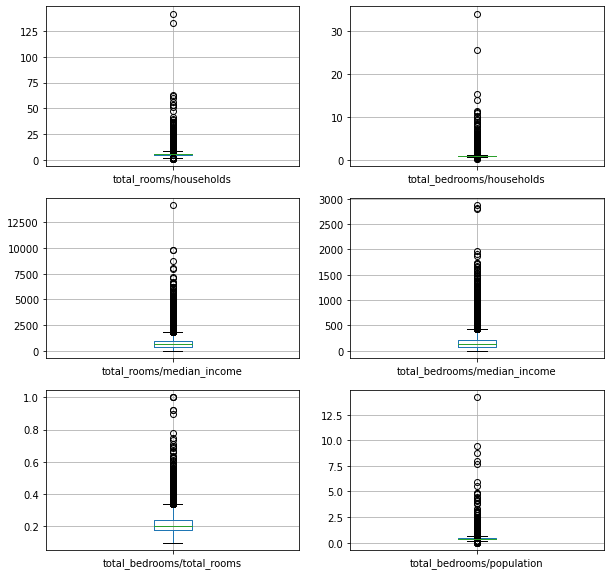

In [ ]:
visualize(dataframe_enriched,
            columns_ratios, 
              n_cols=2, 
              n_rows=3, 
              size=10)

### Geo-plot:
We can ask ourselves, are the nice expnsive houses more located around certain area.

In [ ]:
columns_localization = ["latitude",
          "longitude"]

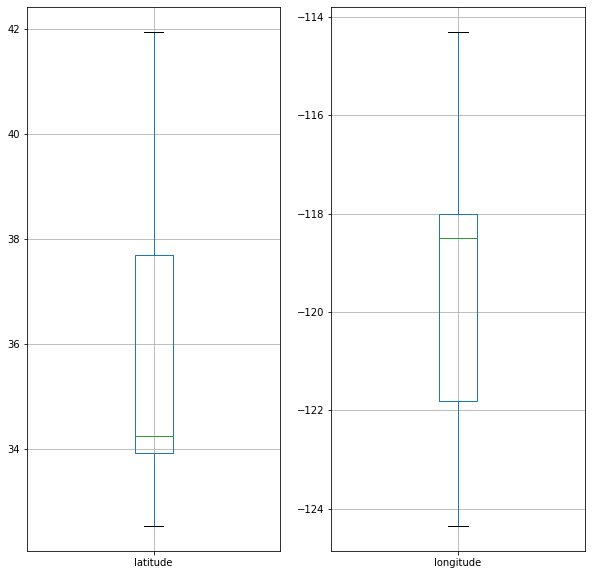

In [ ]:
visualize(data_frame=dataframe_enriched,
              columns=columns_localization,
              n_cols=2, 
              n_rows=1, 
              size=10)

The location seems centered on 
- lat: 32-42  
- long: -124:-114
- more likely not a city because not too concentrated



In [ ]:
x = housing_dataframe['longitude']
y = housing_dataframe['latitude']

# we group the  cities in 100 bins  thanks to the method : pandas.cut
housing_dataframe['binned'] = pd.cut(housing_dataframe['population'].values, bins=100, labels=False)


In [ ]:
# bin the population in 100 bins
c = housing_dataframe['binned'].values
np.unique(c)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34,
       36, 37, 42, 43, 45, 80, 99])

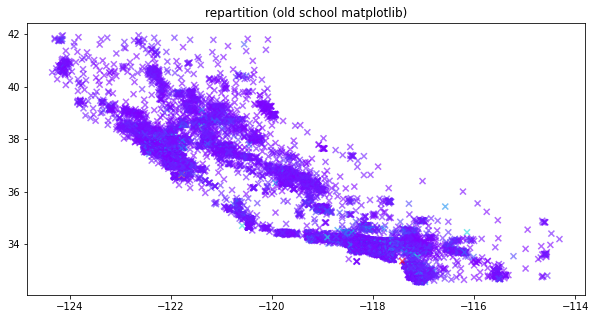

In [ ]:
# display the the median house values locations (matplotlib)
z = housing_dataframe['binned']

plt.figure(figsize=(10,5))
# alpha : transparency
# c : colour list of integers coresponding to each bin
# cmap : color map
plt.scatter(x,y,alpha=0.6, marker='x', c = housing_dataframe['binned'].values, cmap='rainbow')
                                        # alpha :  transparency, marker: shape of the marker
plt.title('repartition (old school matplotlib)')
plt.show()

In [ ]:
# display the the median house values locations (plotly)
fig = px.scatter_mapbox(housing_dataframe, lat="latitude", lon="longitude", color="binned", size="median_house_value",
                  color_continuous_scale=px.colors.carto.Sunset , size_max=10, zoom=10,opacity=0.8,
                  mapbox_style="carto-positron")
fig.show()

In [ ]:
housing_dataframe.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'binned'],
      dtype='object')

## e. Original features: (MICRO glance)


###Distribution of the  variables

[learn more](https://towardsdatascience.com/the-many-ways-to-call-axes-in-matplotlib-2667a7b06e06)

*to do for Assan: apply the log scales*

To output multiple subplots, the figure containing the passed axes is being cleared


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f911369a2d0>,
      dtype=object)

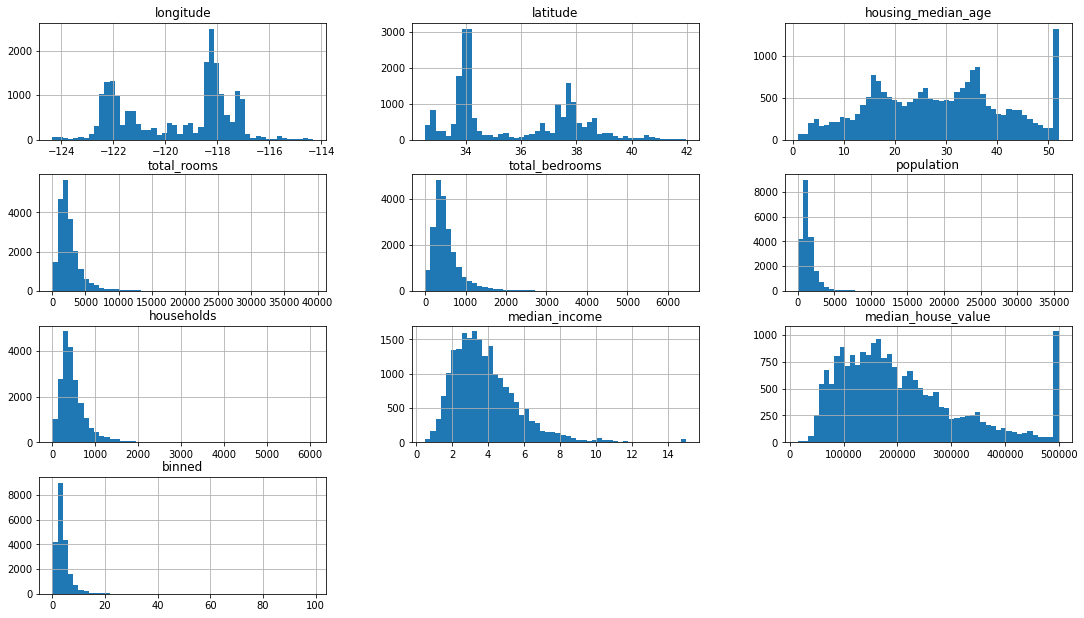

In [ ]:
# matrix of histograms
fig, ax_dsti = plt.subplots(clear=True) # fig : general figure. ax : drawings inside figure
fig.set_size_inches(18.5, 10.5) # figure size
housing_dataframe.hist(ax=ax_dsti, bins=50) # histograms depending of the number of bins
#ax_dsti.set_yscale('log') 

In [ ]:
# box-cox transform
from numpy.random import seed
from numpy.random import randn
from numpy import exp
from scipy.stats import boxcox
from matplotlib import pyplot
# seed the random number generator
seed(1)
housing_dataframe["total_rooms_log_transform"] = boxcox(housing_dataframe["total_rooms"],0)

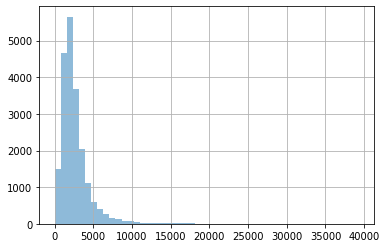

In [ ]:
# without normalizing
housing_dataframe["total_rooms"].hist(bins=50, alpha=0.5)

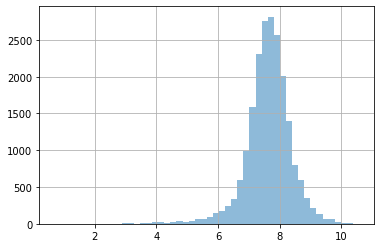

In [ ]:
# without normalizing
housing_dataframe["total_rooms_log_transform"].hist(bins=50, alpha=0.5)

A look at the longitude and latitude shows that the cities are concentrated on
- lat 34 and lat 38
- lat -122 and lat -118

The median income is a skewed gaussian and the median house value as well.

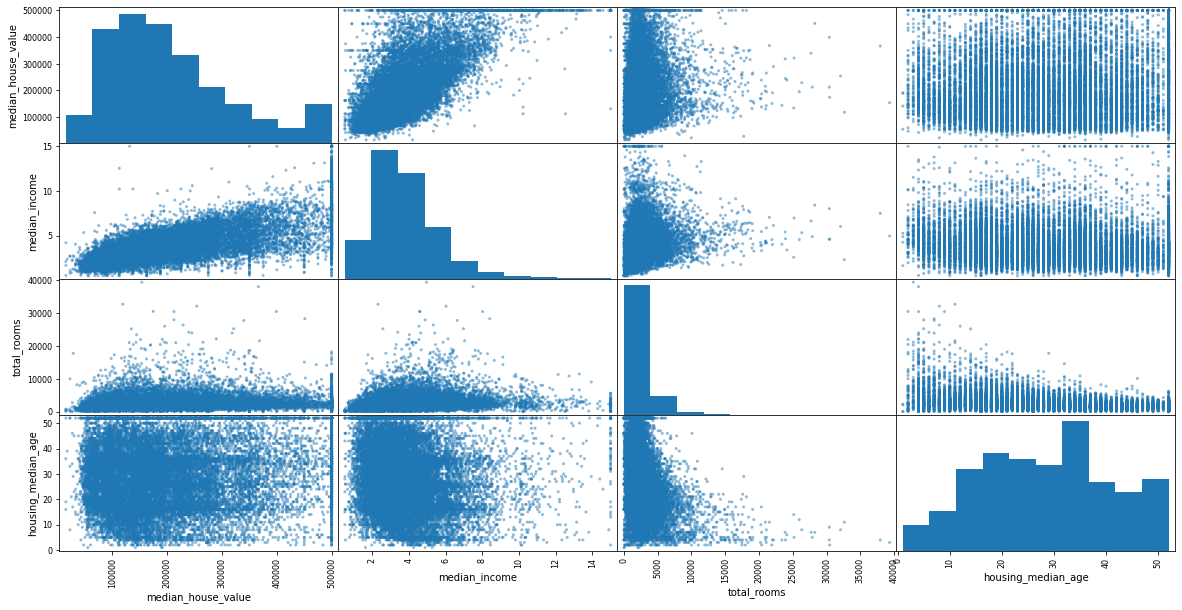

In [ ]:

# relationships between variables and their distribution
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing_dataframe[attributes], figsize=(20, 10))
plt.show()

- median_income shows a horizontal line : values have been capped
- median_house_value values shows a vertical line : values have been capped
- housing_median_age  shows a vertical line : values have been capped

So very likely : when we receive new data, the data must be capped accordingly
Else the values will be in a range the model has not worked with. 

**Other remarks:**
- The median income attribute does not look like it is expressed in US dollars (USD).
- The housing median age and the median house value were also capped.
- 
All attributes have different scales


# Train set - Test set

Creating a test set is theoretically quite simple: just pick some instances randomly, typically 20% of the dataset (or less if your dataset is very large), and set them aside:

#### Simple/Classic train-test separation 

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def split_train_test(data, test_ratio, random_seed=42):
  '''
  train & test split  via numpy
  '''
  shuffled_indices = np.random.RandomState(seed=random_seed).permutation(len(data))  # Set the seed so that you can retrieve the result
  test_set_size = int(len(data) * test_ratio) #To use for slicing, cast it into integer
  test_indices = shuffled_indices[:test_set_size] #If you want to add train_set_size train_set_size = int(len(data)*1-test_ratio)
  train_indices = shuffled_indices[test_set_size:] 
  return data.iloc[train_indices], data.iloc[test_indices] # Tuple of DataFrames

In [ ]:
def split_train_test_pandas(data_frame, test_ratio, random_seed =42):
  '''
  train & test split via pandas
  '''
  shuffled_data_frame = data_frame.sample(frac=1, random_state=random_seed).reset_index(drop=True) #frac = 1 is same as shuffling, reset_idex for the convenience
  train_dataframe = shuffled_data_frame.iloc[:-int(test_ratio*shuffled_data_frame.shape[0]),:] # We start from 0 to int(test_ratio*shuffled_data_frame.shape[0])
  test_dataframe = shuffled_data_frame.iloc[-int(test_ratio*shuffled_data_frame.shape[0]):,:] # from int(test_ratio*shuffled_data_frame.shape[0] to the end
  return train_dataframe, test_dataframe

In [ ]:
def split_train_test_sklearn(data_frame, test_ratio, random_seed =42):
  '''
  train & test split  via sklearn
  '''
  train_dataframe, test_dataframe = train_test_split(data_frame,test_size=test_ratio, random_state=random_seed) # This is from the scikit-learn library
  return train_dataframe, test_dataframe

3 ways to implement data splitting:

> Indented block





In [ ]:
train_df, test_df = split_train_test(housing_dataframe, test_ratio=0.2)

In [ ]:
pd_train_df, pd_test_df = split_train_test_pandas(housing_dataframe, test_ratio=0.2)

In [ ]:
sk_train_df, sk_test_df = split_train_test_sklearn(housing_dataframe, test_ratio=0.2)

We can see that method sklearn and method numpy yield same results - they use both the same implementation

### Data preparation

In order to have our data ready, we now know that we must:
- normalize some variates
- fill missing values
- standardize variates
- stratify the split

All these initial operations can be performed via  **Transformers** & **Pipelining**

In [ ]:
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

In [ ]:
housing_dataframe = pd.read_csv('datasets/housing/housing.csv')

- You need Transformer and you can turn this into Pipeline. 
- We have Transformer that are shipped with Scikit-learn 
- but you will have to create your own Transformer(Custom Transformer)

In [ ]:
class CombinedAttributesAddor(BaseEstimator, TransformerMixin):
  
  def __init__(self, 
               cols,
               add_bedrooms_per_room = True,
               add_population_per_household = True,
               add_rooms_per_household = True
               ): # no *args or **kargs
    self.cols = cols

    #
    self.idx_mapping = dict(zip(cols,range(len(self.cols))))

    # new features
    self.add_population_per_household = add_population_per_household
    self.add_rooms_per_household = add_rooms_per_household
    self.add_bedrooms_per_room = add_bedrooms_per_room 

    # keep track of new column names
    self.new_cols = []
    return

  def fit(self, X, y=None):
    return self # nothing else to do def transform(self, X, y=None):
  
  def transform(self, X, y=None):

    #
    bedrooms_idx = self.idx_mapping["total_bedrooms"]
    rooms_idx = self.idx_mapping["total_rooms"]
    households_idx = self.idx_mapping["households"]
    population_idx = self.idx_mapping["population"]




    if type(X) != np.ndarray:
      X = X.values

    if self.add_rooms_per_household:
      bedrooms_household = X[:, bedrooms_idx ]/ X[:,households_idx] 
      self.new_cols.append("bedrooms/household")
    if self.add_population_per_household:
      population_per_household = X[:, population_idx ] / X[:, households_idx] 
      self.new_cols.append("population/household")
    if  self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_idx] / X[:,rooms_idx]
      self.new_cols.append("bedrooms/rooms")
    
    return np.c_[X,
                 bedrooms_household,
                 population_per_household,
                 bedrooms_per_room]

At minimum, you need to write this

In [ ]:
class DummyTransformer(BaseEstimator, TransformerMixin):
  
  def __init__(self): # no *args or **kargs
    pass

  def fit(self, X, y=None):
    return self # nothing else to do def transform(self, X, y=None):
  
  def transform(self, X, y=None):
    return X 

In [ ]:
class DummyTransformer(BaseEstimator, TransformerMixin):
  
  def __init__(self, parameter1, parameter2): # no *args or **kargs
    self.parameter1 = parameter1 # You need to follow this syntax
    self.parameter2 = parameter2

  def fit(self, X, y=None):
    return self # nothing else to do def transform(self, X, y=None):
  
  def transform(self, X, y=None):
    return X+self.parameter1 - self.parameter2 # Pay attention to add self before variables

In [ ]:
class DummyTransformer(BaseEstimator, TransformerMixin):
  
  def __init__(self): # no *args or **kargs
    pass

  def fit(self, X, y=None):
    return self # nothing else to do def transform(self, X, y=None):
  
  def transform(self, X, y=None):
    return X.mean(axis=0)

In [ ]:
X = housing_dataframe

In [ ]:
X = X.select_dtypes(exclude="object").values # Select numerical values

In [ ]:
 dummy_transformer = DummyTransformer() # We need to instantiate the Class
dummy_transformer.transform(X)

array([-1.19569704e+02,  3.56318614e+01,  2.86394864e+01,  2.63576308e+03,
                   nan,  1.42547674e+03,  4.99539680e+02,  3.87067100e+00,
        2.06855817e+05])

In [ ]:
myDearPipeline = Pipeline([                                   # One-Step Pipeline
                      ("Dummy", DummyTransformer())  # You set Class as if you instantiate it.
])

In [ ]:
myDearPipeline.fit_transform(X)

array([-1.19569704e+02,  3.56318614e+01,  2.86394864e+01,  2.63576308e+03,
                   nan,  1.42547674e+03,  4.99539680e+02,  3.87067100e+00,
        2.06855817e+05])

In [ ]:
#parameter: min, max, mean, median
class NotSoDummyTransformer(BaseEstimator, TransformerMixin):
  
  def __init__(self, flag = 'mean'): # no *args or **kargs
    self.flag = flag
    

  def fit(self, X, y=None):
    return self # nothing else to do def transform(self, X, y=None):
  
  #according to the value of 'flag', we will perform different actions
  def transform(self, X, y=None):
    #if X parameter is a dataframe, the X received here is a ndarray !!!

    #variable connected to the class => self mandatory
    self.XX = None

    if self.flag == 'mean':
         self.XX = X.mean(axis=0)

    elif self.flag == 'max':
         self.XX = X.max(axis=0)

    elif self.flag == 'min':
         self.XX = X.min(axis=0)

    elif self.flag == 'median':
         self.XX = np.median(X, axis=0)  

    else:
        self.XX = X

    return self.XX

In [ ]:
dummy_transformer = NotSoDummyTransformer() # We need to instantiate the Class
dummy_transformer.transform(X)

array([-1.19569704e+02,  3.56318614e+01,  2.86394864e+01,  2.63576308e+03,
                   nan,  1.42547674e+03,  4.99539680e+02,  3.87067100e+00,
        2.06855817e+05])

In [ ]:
dummy_transformer = NotSoDummyTransformer('min') # We need to instantiate the Class
dummy_transformer.transform(X)

array([-1.2435e+02,  3.2540e+01,  1.0000e+00,  2.0000e+00,         nan,
        3.0000e+00,  1.0000e+00,  4.9990e-01,  1.4999e+04])

In [ ]:
#If i want a max calculation, i need to put 'max' in my transformer init
myDearPipeline = Pipeline([                                   # One-Step Pipeline
                      ("Dummy", NotSoDummyTransformer('max'))  # You set Class as if you instantiate it.
])

In [ ]:
myDearPipeline.fit_transform(X)

array([-1.14310e+02,  4.19500e+01,  5.20000e+01,  3.93200e+04,
                nan,  3.56820e+04,  6.08200e+03,  1.50001e+01,
        5.00001e+05])

In [ ]:
dummy_transformer.transform(housing_dataframe)

longitude               -124.35
latitude                  32.54
housing_median_age            1
total_rooms                   2
total_bedrooms                1
population                    3
households                    1
median_income            0.4999
median_house_value        14999
ocean_proximity       <1H OCEAN
dtype: object

In [ ]:
myDearPipeline.fit_transform(housing_dataframe)

longitude                -114.31
latitude                   41.95
housing_median_age            52
total_rooms                39320
total_bedrooms              6445
population                 35682
households                  6082
median_income            15.0001
median_house_value        500001
ocean_proximity       NEAR OCEAN
dtype: object

In [ ]:
MyLastPipeline = Pipeline([
    ('scaling', StandardScaler()), 
    ('NotSoDummy', NotSoDummyTransformer('median'))
])

In [ ]:
MyLastPipeline.fit_transform(housing_dataframe.select_dtypes(exclude="object"))

array([ 0.53891366, -0.6422871 ,  0.02864572, -0.23321042,         nan,
       -0.22913175, -0.23681619, -0.17679508, -0.23533368])